# Introduction

For this project, the data used contains relevant characteristics that cars have. The Dataset consists of 3575 observations, reduced to 2418 after removing NA values.
I decided to just remove the NA values instead of taking a different approach, given that I intended to have a DataSet of about 2000 observations in the first place. Therefore, removing the NA values gives me the desired size of the DataSet, while improving it's quality by having no missing values in it.

The main purpose for this project is to determine if any of the given variables have any relation to a car's prices(MSRP).

To achieve this, all of the models seen in class will be implemented:
    - Decision Trees
    - Boosting
    - Bagging
    - Random Forests

# Data

This dataset can be obtained from Kaggle: https://www.kaggle.com/CooperUnion/cardataset

It contains the following variables:

__Make:__ The brand that manufactures the car.

__Model:__ Specific line of car.

__Year:__ Year the car was produced.

__Engine Fuel Type:__ Type of fuel the car uses.

__Engine HP:__ Ammount of HorsePower that the car has.

__Engine CY:__ Ammount of Cylinders in the engine of the car.

__Transmission:__ Gearbox type.

__Driven Wheels:__ The car's drive; Front, Rear or all.

__Number of Doors:__ Ammount of doors on the car.

__Market Category:__ The market the car is aimed for.

__Vehicle Size:__ Size of the car.

__Vehicle Style:__ The type of the car; Hatchback, sedan, SUV, etc.

__Highway MPG:__ MPG the car achieves on average in the Highway.

__City MPG:__ MPG the car achieves on average in the city.

__Popularity:__ How popular the brand is.

__MSRP:__ Retail Price of the car.

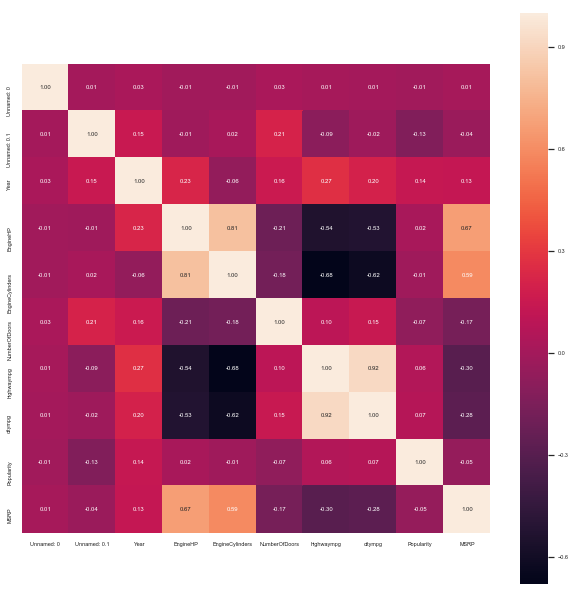

In [92]:
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(rc={"figure.figsize":(10.5,10.5)})

numcar1 = cars.drop(columns="Make")
numcar2 = numcar1.drop(columns="Model")
numcar3 = numcar2.drop(columns="FuelType")
numcar4 = numcar3.drop(columns="Transmission")
numcar5 = numcar4.drop(columns="Drive")
numcar6 = numcar5.drop(columns="MarketCategory")
numcar7 = numcar6.drop(columns="Size")
numcar = numcar7.drop(columns="Style")

#numcar = cars['Year','EngineHP','EngineCylinders','NumberOfDoors','highwaympg','citympg','Popularity','MSRP']

cols = list(numcar)
cm = np.corrcoef(numcar.values.T)
sns.set(font_scale=.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", yticklabels=cols, xticklabels=cols)

In the HeatMap we can observe that the observations that show the stronger link towards MSRP are:
- Highway MPG
- City MPG
- Populartity

The three of them show a weak correlation, but the stronger of the bunch nevertheless.

# Hypothesis

Taking what I know about cars into consideration, and after taking a quick look at the data. I'd predict that the values that will show the stronger link to the target value (MSRP) will be:

- Engine HP

- Market Category

Engine HP matters because that's the number everyone has on their mind. People tend to think that Higher HP means a better car.
There's even a famous quote that says 'HP sells cars, Torque wins races'

Market Category might be relevant given that luxury cars are usually much more expensive than say Hatchbacks.

In [93]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Click <a href="javascript:code_toggle()">here</a> to hide the code.''')

In [94]:
## ---------------------------------- IMPORTS -----------------------------------##
! pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import requests
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import graphviz 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.feature_selection import rfe
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline

In [95]:
## ---------------------------------- IMPORT THE DATA -------------------------------##
cars = pd.read_csv('CleanData.csv')
carnp = cars.drop(columns="MSRP") ## Remove MSRP from this dataset for it to be used where the target value must not be included.
print("DataSet Shape: ")
cars.shape

DataSet Shape: 


(2418, 18)

In [96]:
print('DataSet Head:')
cars.head(3)

DataSet Head:


,Unnamed: 0,Unnamed: 0.1,Make,Model,Year,FuelType,EngineHP,EngineCylinders,Transmission,Drive,NumberOfDoors,MarketCategory,Size,Style,highwaympg,citympg,Popularity,MSRP
0,4,747,Volvo,740,1991,regular unleaded,162.0,4.0,AUTOMATIC,rear wheel drive,4.0,"Luxury,Performance",Midsize,Sedan,20,17,870,2000
1,6,4759,Ford,Flex,2016,premium unleaded (recommended),365.0,6.0,AUTOMATIC,all wheel drive,4.0,Crossover,Large,Wagon,21,15,5657,42600
2,7,6423,Acura,Legend,1994,regular unleaded,230.0,6.0,MANUAL,front wheel drive,2.0,"Luxury,Performance",Midsize,Coupe,24,16,204,2384


In [97]:
print('DataSet Tail')
cars.tail(3)

DataSet Tail


,Unnamed: 0,Unnamed: 0.1,Make,Model,Year,FuelType,EngineHP,EngineCylinders,Transmission,Drive,NumberOfDoors,MarketCategory,Size,Style,highwaympg,citympg,Popularity,MSRP
2415,3568,11613,Volvo,XC70,2016,regular unleaded,240.0,4.0,AUTOMATIC,front wheel drive,4.0,"Crossover,Luxury",Midsize,Wagon,31,23,870,46675
2416,3570,9010,GMC,Savana Cargo,2015,flex-fuel (unleaded/E85),285.0,8.0,AUTOMATIC,rear wheel drive,3.0,Flex Fuel,Large,Cargo Van,17,11,549,31415
2417,3572,5025,Ford,Fusion Hybrid,2016,regular unleaded,188.0,4.0,AUTOMATIC,front wheel drive,4.0,Hybrid,Midsize,Sedan,41,44,5657,25675


# Methods

# 1. Decision Trees

It's a flowchart like tree structure, where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class labe

#### Strengths of the Decision Tree

- Decision trees are able to generate understandable rules.

- Decision trees perform classification without requiring much computation.

- Decision trees are able to handle both continuous and categorical variables.

- Decision trees provide a clear indication of which fields are most important for prediction or classification.

#### Weaknesses of the Decision Tree

- Decision trees are less appropriate for estimation tasks where the goal is to predict the value of a continuous attribute.
- Decision trees are prone to errors in classification problems with many class and relatively small number of training examples.
- Decision tree can be computationally expensive to train. The process of growing a decision tree is computationally expensive. At each node, each candidate splitting field must be sorted before its best split can be found. In some algorithms, combinations of fields are used and a search must be made for optimal combining weights. Pruning algorithms can also be expensive since many candidate sub-trees must be formed and compared.

## How could this method help with the objective of the project


This could be a useful method given the simplicity it has. It's very easy to understand what it means.
It's also useful that it's able to work with both numerical and categorical variables.

This method can help us classify or predict the observations as well as possible.

It will also help us measure how well we meet our goal with Impurity(Gini)

In [98]:
brands = cars.Make
keep_features = [
 'Year',
 'EngineHP',
 'EngineCylinders',
 'Transmission',
 'Drive',
 'MarketCategory',
 'Size',
 'Style',
 'highwaympg', 
 'citympg',
 'Popularity',
]
labels = cars[cars['Make'].isin(brands)]['Make']
features = cars[cars['Make'].isin(brands)][keep_features]
imputer = SimpleImputer(strategy='mean')
features['EngineHP']  = imputer.fit_transform(features[['EngineHP']])
feature_dummies = pd.get_dummies(features)

##Split the Data
X_train, X_test, y_train, y_test = train_test_split(feature_dummies, labels, test_size=0.30, random_state=200)

#### Graphing the Tree and Results 

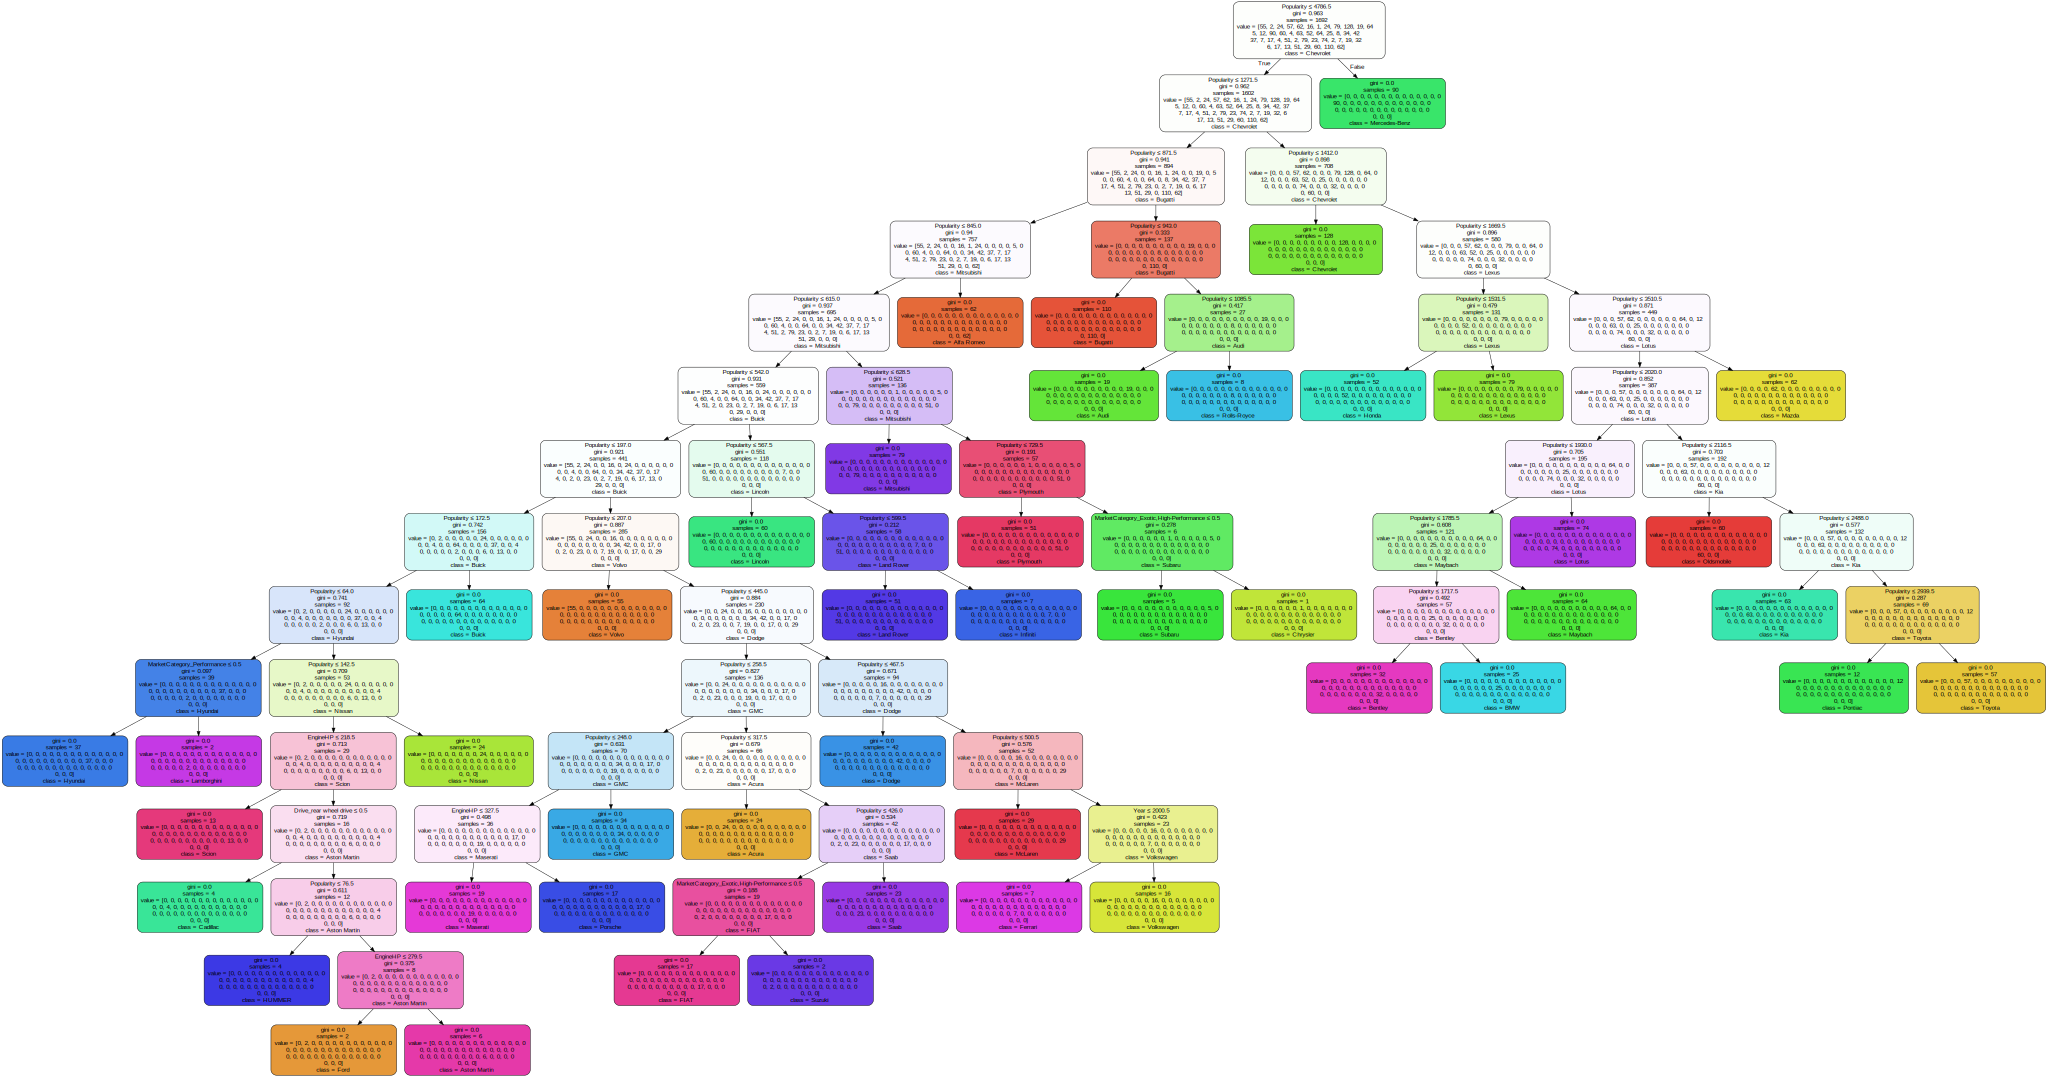

In [99]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

dot_data = export_graphviz(clf, out_file=None, 
                     feature_names=feature_dummies.columns,  
                     class_names=labels.unique(),  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [100]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#### Accuracy Score

In [101]:
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9972451790633609

#### Classification Report

In [102]:
print(classification_report(y_pred, y_test))

               precision    recall  f1-score   support

        Acura       1.00      1.00      1.00        24
 Aston Martin       1.00      1.00      1.00         7
         Audi       1.00      1.00      1.00        25
          BMW       1.00      1.00      1.00        18
      Bentley       1.00      1.00      1.00         6
        Buick       1.00      1.00      1.00         9
     Cadillac       1.00      1.00      1.00        38
    Chevrolet       1.00      1.00      1.00        59
     Chrysler       1.00      1.00      1.00         9
        Dodge       1.00      1.00      1.00        30
         FIAT       1.00      1.00      1.00         7
      Ferrari       1.00      1.00      1.00        11
         Ford       1.00      1.00      1.00        48
          GMC       1.00      1.00      1.00        33
      Genesis       0.00      0.00      0.00         0
       HUMMER       1.00      1.00      1.00         3
        Honda       1.00      1.00      1.00        35
      Hyu

C:\Anaconda\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Confussion Matrix

Confusion matrix, without normalization
[[24  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 25 ...  0  0  0]
 ...
 [ 0  0  0 ... 25  0  0]
 [ 0  0  0 ...  0 50  0]
 [ 0  0  0 ...  0  0 20]]


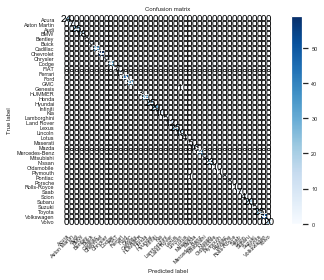

In [103]:
plot_confusion_matrix(y_true=y_test, y_pred=y_pred,
                      title='Confusion matrix')

#### Comparing Predicted value to Actual Value

In [104]:
[unique_labels(y_test, y_pred)]
pd.DataFrame({'Actual': y_test,'Predictions': y_pred}).head(5)

,Actual,Predictions
256,Toyota,Toyota
355,Chevrolet,Chevrolet
2186,Ford,Ford
898,HUMMER,HUMMER
70,Hyundai,Hyundai


## Results of the Decision Tree

We can see that the Tree is fairly big, this is because it's taking into account all of the features of the DataSet.
As for the accuracy test; it returned a very high value at __0.99__. This could mean two things:
- The DataSet is perfectly set, and the tree is able to classify every feature correctly.
- There's some mistake in the making of the Tree which is the reason of it recording such a high value.

Taking a look at the Classification Report obtained, we can see that most of the values (Brands in this case) is at 1.00. With a few excpetions which are:
- Lincoln
- Genesis, which actually got 0.00 in precision, recoll and f1 scores

The same could be said about the Confussion Matrix, given that it records some high values, but for the most part it just stays at 0.

Given the results obtained from the Tree, I'd say that this method could turn out to be just confusing. I don't think a 0.99 score makes sense in this case, yet I've tried many things to fix it, such as changing the way the algorithm takes 'brand', for example, I tried making a list with all of the names and filtering the cars.make with it, and that returned a result of 1.00.

I also tried changing the features and observations used in many combinations. 

Tried filtering the dataset by area of brands, so I'd have multiple tree for European, Asian and American cars. That returned a 1.00 value aswell.

For those reasons, I've decided to not take into account this method in the final result analysis. Nevertheless, it holds value to include it to understand how the Decision Tree works.

# 2. Random Forest, Boosting & Bagging

It's an ensemble of Decision Trees, in this case trained with the __bagging__ method. The general idea of the bagging method is that a combination of learning models increases the overall result.

Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.

Things to know:

- The __N_jobs__ hyperparameter tells the engine how many cores it's allowed to use.
- The __Random State__ makes the model's output replicable.
- The __OOB Score__ is a cross validation method. Some of the data is not used to train the model, and it can be used to evaluate it's performance.

__Advantages__:
- It can be used for regression and classification tasks.
- Easy to use and understand
- Very unlikely for it to underfit.

__Disadvantages__:
- Because of the ammount of trees it uses, it can be slow.
- It's not a descriptive tool.

## How could this Method help with the Project?

Just like the decision trees, this method can be useful to correctly predict the observations.
It will help us to a greater extent given that it's base is actually a decision tree, but it uses many of them to come out with a better ressult.

In [105]:
cars.dropna(axis=0, subset=['MSRP'], inplace=True)

labels = cars['MSRP']
features = cars.drop('MSRP', axis=1)

category = features.select_dtypes(object).astype('category') ## Turn objects into category
category = pd.get_dummies(category)

numeric = features.select_dtypes(include=[int,float]) ## Get numeric values

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
numeric =  pd.DataFrame(imputer.fit_transform(numeric), columns=numeric.columns, index=numeric.index)

features_clean = category.join(numeric)

X_train, X_test, y_train, y_test = train_test_split(features_clean, labels, test_size=0.30, random_state=202)

clf = RandomForestRegressor(n_estimators=200, n_jobs=-1) 
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [106]:
clf.estimators_[0:5]

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1022798137, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=975439840, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=472400443, splitter='best'),
 DecisionTreeRegresso

#### Plot the Forest:

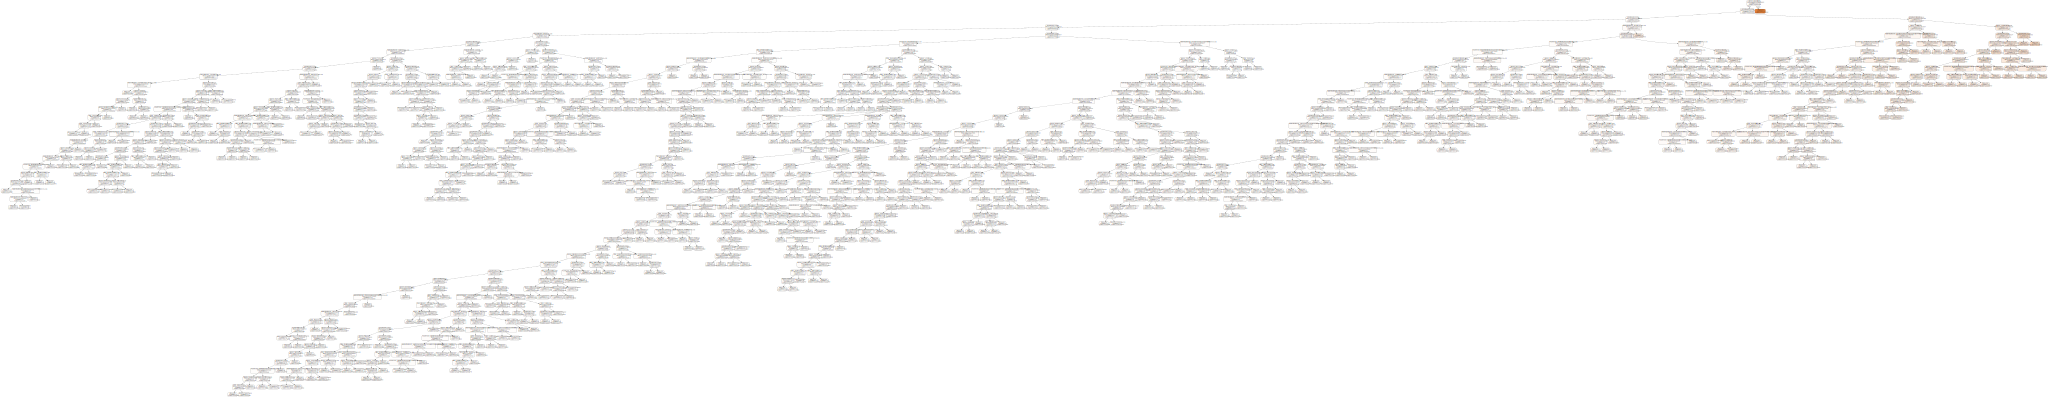

In [107]:
dot_data = export_graphviz(clf.estimators_[0], out_file=None, 
                     feature_names=features_clean.columns,  
                     class_names=labels.unique(),  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

### Getting into the Metrics

###  Individual Performance

In [108]:
tree_predictions = clf.estimators_[0].predict(X_test)
print('R2 Score: ')
r2_score(y_test, tree_predictions)

R2 Score: 


0.8772057084555259

In [109]:
print('Mean Squared Error: ')
sqrt(mean_squared_error(y_test, tree_predictions))

Mean Squared Error: 


20794.853791269357

###  Performance of the entire forest

In [110]:
forest_preditions = clf.predict(X_test)
print('R2 Score: ')
r2_score(y_test, forest_preditions)

R2 Score: 


0.9216594891931547

In [111]:
print('Mean Squared Error: ')
sqrt(mean_squared_error(y_test, forest_preditions))

Mean Squared Error: 


16609.63090448301

#### Graph:

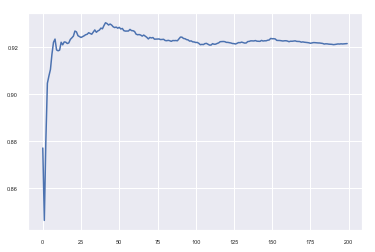

In [112]:
preds = np.stack([t.predict(X_test) for t in clf.estimators_]) 
plt.plot([r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(clf.n_estimators)])

## HyperParameters

### OOB Score

In [113]:
clf = RandomForestRegressor(n_estimators=200, 
                            oob_score=True, 
                            n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.oob_score_, r2_score(y_test, pred)

(0.6494312631202196, 0.9223573706008945)

#### OOB Score and R2 Score with min sample leaf of 2

In [114]:
%%time
clf = RandomForestRegressor(n_estimators=200, 
                            oob_score=True,
                            min_samples_leaf=2,
                            n_jobs=-1,
                            bootstrap=True)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(clf.oob_score_, r2_score(y_test, pred))

0.5973975781300704 0.9075962517035512
Wall time: 1.55 s


#### R2 Score

In [115]:
%%time
clf = ExtraTreesRegressor(n_estimators=200, 
#                             min_samples_leaf=3,
                            max_features=0.5,
                            max_depth = 7,
                            n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(r2_score(y_test, pred))

0.8835635414494732
Wall time: 751 ms


## Features Importance

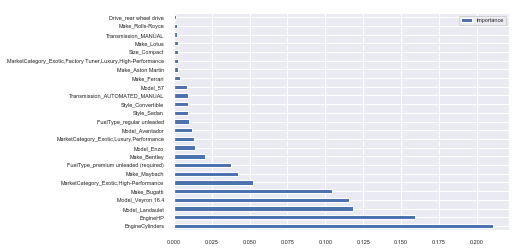

In [116]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.iloc[0:25].plot.barh()

In [117]:
feature_importances[feature_importances['importance']> feature_importances['importance'].mean()].head()

,importance
EngineCylinders,0.210213
EngineHP,0.159321
Model_Landaulet,0.118006
Model_Veyron 16.4,0.115418
Make_Bugatti,0.104193


#### OOB Score

In [118]:
subset_feat = feature_importances[feature_importances['importance']> feature_importances['importance'].mean()].index

clf = RandomForestRegressor(n_estimators=500, 
                            oob_score=True,
                            min_samples_leaf=2,
                            n_jobs=-1,
                            bootstrap=True)
clf.fit(X_train[subset_feat], y_train)
pred = clf.predict(X_test[subset_feat])

print(clf.oob_score_, r2_score(y_test, pred))

0.6040424294661624 0.9001667174872883


## Boosting

In [119]:
auto_sub = cars[['FuelType', 'EngineHP', 'EngineCylinders', 'NumberOfDoors','highwaympg', 'citympg', 'Popularity']]
y = cars['MSRP']
yc = cars['Make']
auto_category = auto_sub.select_dtypes(object).astype('category')
auto_category = pd.get_dummies(auto_category)

auto_numeric = auto_sub.select_dtypes(exclude='object')
auto_final = auto_category.join(auto_numeric)
auto_final.tail()

X_train, X_test, y_train, y_test = train_test_split(auto_final, y, test_size=0.30, random_state=100)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(auto_final, yc, test_size=0.30, random_state=100)

### Adaboost Regression

In [120]:
adaboost_reg = AdaBoostRegressor(n_estimators=200, learning_rate=1, loss='linear')
adaboost_reg.fit(X_train, y_train)

prediction_train = adaboost_reg.score(X_train,y_train)
prediction_test = adaboost_reg.score(X_test,y_test)

print('Prediction Train: ')
print(prediction_train)
print('')
print('Prediction Test: ')
print(prediction_test)

Prediction Train: 
0.7574076813496254

Prediction Test: 
0.558383942166218


### Adaboost Classification

In [121]:
AdaBoost = AdaBoostClassifier(n_estimators=200,learning_rate=1,algorithm='SAMME')
AdaBoost.fit(Xc_train,yc_train)
c_pred_train = AdaBoost.score(Xc_train,yc_train)
c_pred_test = AdaBoost.score(Xc_test,y_test)

print('C_Pred Train: ')
print(c_pred_train)
print('')
print('C_Pred Test: ')
print(c_pred_test)

C_Pred Train: 
0.23286052009456265

C_Pred Test: 
0.0


### XGBoost

In [122]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {'booster': 'gbtree', 'max_depth': 5, 'eta': 0.8, 'gamma': .01}

num_round = 100
bst = xgb.train(param, dtrain, num_round)

y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

print('R2 Score of Train: ')
print(r2_score(y_train, y_train_pred))
print('')
print('R2 Score of Test')
print(r2_score(y_test, y_test_pred))

R2 Score of Train: 
0.9059127942729333

R2 Score of Test
0.6577271841483212


C:\Anaconda\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# Results of Random Forests

__Random Forest__

This was interesting. I started with a very small Forest with 20 Trees in it. The results were half decent to say something.
The individual trees performed okay at 0.86, and the forest actually got better at 0.91.

I then increased to 200 Trees, and as expected the results got better.
The individual trees however got a bit worse, as they downed from 0.86 to 0.83. The Forest itself however, went from 0.91 to 0.92, which means it increased it's accuracy.

After doing that, I increased the ammount to 500 trees in hopes to get even better results from that, however, the results actually went down.
With 500 Trees, the individual performance went up, getting to 0.85, and the Forest droped from 0.92 to 0.90, which is the worst of the three tests.

For this to be more evident, I'll list the results of the three tests below:

- 20 trees: Individual: 0.86 | Forest: 0.91
- 200 trees: Individual: 0.83 | Forest: 0.92
- 500 trees: Individual: 0.85 | Forest: 0.90

__OOB Score__

Because of the previous analysis, I'll focus mainly on the results obtained from the 200 trees forest.
The OOB score obtained from 200 trees was 0.655 for the y_test. And 0.921 for the X_test.

Again, these are the highest values of the bunch, except for the X_test's which is nearly tied to that of the 500 trees' Forest.

__OOB Score with minimum ammount of sample leafs(2)__

The R2 score recorded for the Y_test was 0.593, while the R2 Score for X_test was 0.907.

These are actually the lowest values when compared to their equivalents with 20 and 500 trees.

__Pure R2 Score__

This time, the values were really close together, however, the value recorded in the 200 trees forest was the highest at 0.879.

__Features Importance__ 

Engine Cylinders and Engine HP were the two most important features. This not only makes sense as those are the two values that people tend to look for in cars, it also makes sense when you take into consideration that usually cars with more cylinders will make more HP, so they could be correlated themselves.

# Results of Boosting

__AdaBoost Regression__

The recorded prediction value for the Training Dataset was of 0.680. The recored value for the Testing DataSet was 0.448. These values were actually not the highest values. The AdaBoost Regression test returned higher values when using 20 estimators.

__Adaboost Classification__

For this test, the recorded values for the Training Dataset was 0.232.
This was the middle value obtained. When using 20 estimators, the value was lower. However, when using 500 estimators, the value went up.

__XGBoost__

Lastly, with the XGBoost method, the recorded R2 score for the train dataset was of 0.905, and for the testing dataset, it was 0.65

# Overall Results discussion

The Random Forest Method was far better than the decision trees because the results it returned made much more sense.

After testing multiple values, the best scoring forest was determined to be the one with 200 trees in it.

It returned something like an inverse parabola, because with low ammount of trees it returned low values, but if you added too many trees, it started to decrease again.

The OOB score further supported this as it returned the higher values with 200 estimators.

The R2 Score, again, supported this statement as it also recorded the highest values with 200 estimators.

As for boosting, this is were it get interesting because the Regression Boosting Method showed that the Forest with 20 trees would get the best score.

The Classification returned that the best score would be achieved when using 500 estimators.


# 3. Cross Validation

# 3.1 K-Folds Cross-Validation

It is used in applied machine learning to compare and select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The general procedure is as follows:

- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
  - Take the group as a hold out or test data set
  - Take the remaining groups as a training data set
  - Fit a model on the training set and evaluate it on the test set
  - Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores

In [123]:
y = cars['MSRP'] ## Response variable
y_fuel = cars['FuelType'] ## Categorical Response variable with few levels
yc = cars['Make'] ## Categorical Response variable
adaboost_reg = AdaBoostRegressor(n_estimators=200, learning_rate=1, loss='linear')

### K-Folds CV

In [124]:
# prepare cross validation
kfold = KFold(n_splits=5, shuffle=False, random_state=91)
# correct = 0

for train, test in kfold.split(auto_final):

    adaboost_reg.fit(auto_final.iloc[train], y.iloc[train])
    prediction_train = adaboost_reg.score(auto_final.iloc[train], y.iloc[train])
    prediction_test = adaboost_reg.score(auto_final.iloc[test], y.iloc[test])
#     correct += prediction_test
    print('Prediction for Train: ')
    print(prediction_train)
    print('')
    
    print('Prediction for Test: ')
    print(prediction_test)
    print("\n")

Prediction for Train: 
0.8286981983196241

Prediction for Test: 
0.4501501731108293


Prediction for Train: 
0.8402491390436018

Prediction for Test: 
0.7241036829392817


Prediction for Train: 
0.8259409581302246

Prediction for Test: 
0.7429336863837451


Prediction for Train: 
0.8914360091164141

Prediction for Test: 
0.5463480631437105


Prediction for Train: 
0.8373162708398261

Prediction for Test: 
0.6553701783236359




# Results for K-Fold CV

As I said before, the algorithm works in a Loop where it will shuffle the data randomly, then it will split it into K groups and finally, it will summarize the skill of the model.

We can see that the Highest value for the Training DS was 0.86, and the lowest was 0.82.

As for the Testing DS, the highest value was 0.74 and the lowest was 0.54.

The Training DS stayed at a pretty high value on average, whereas the Testing DS dropped to 0.54 which is considered to be fairly low.

With this, we could conclude that the skill level of our training DS is significantly higher than that of the Testings DS

# 3.2 Leave One Out Cross Validation

It uses a single observation from the original sample as the validation data, and the remaining observations as the training data. This is repeated such that each observation in the sample is used once as the validation data.

Leave-one-out cross-validation is usually very expensive from a computational point of view because of the large number of times the training process is repeated

In [125]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

correct_train = 0
correct_test = 0
for train, test in loo.split(auto_final):

    adaboost_reg.fit(auto_final.iloc[train], y.iloc[train])
    prediction_train = adaboost_reg.score(auto_final.iloc[train], y.iloc[train])
    prediction_test = adaboost_reg.score(auto_final.iloc[test], y.iloc[test])
    correct_train += prediction_train
    correct_test += prediction_test
#     print(prediction_train)
#     print(prediction_test)
#     print("\n")

print('Correct Train: ')
print(correct_train/len(auto_final))
print(correct_test/len(auto_final))

Correct Train: 
0.8138070544218854
0.0


# Results for LOOCV

The final result obtained is 0.81, which is not exactly high but it's not low either. It's also fair to point out that this method does indeed take some computational power, and so does it take a bit of time to proccess.

What this score means is the performance for all of the features when 1 of them is left out and used for testing. So the score means that the performance is quite high for all of the features.

# 3.3 Feature Importance

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in.

Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

__Benefits:__

- Reduces Overfitting
- Improves Accuracy
- Reduces Training Time

In [126]:
estimator = LogisticRegression()
selector = rfe.RFE(estimator, 5, step=1)
selector.fit(auto_final, y_fuel)
# selector.support_ 
print(selector.ranking_)
selector.n_features_

C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed

[ 1  9  3  2  1  1  1  1  8  4  5  7  6 10]


C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed

5

In [127]:
kb = SelectKBest(k=3)
print('Feature scores')
print(kb.fit(auto_final, y_fuel).scores_)
print('\n')
print('P-values')
print(kb.fit(auto_final, y_fuel).pvalues_)
X_new = kb.fit_transform(auto_final, y_fuel)

Feature scores
[         inf          inf          inf          inf          inf
          inf          inf          inf 181.65607427  97.80856992
  24.56615271 145.97959172 190.94216021  17.80168045]


P-values
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 1.93842685e-216 4.89482045e-126 1.52963108e-032 7.71067738e-180
 1.45624721e-225 3.51808617e-023]


C:\Anaconda\Anaconda\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Anaconda\Anaconda\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Anaconda\Anaconda\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [128]:
kb.get_support()

array([False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False])

In [129]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(auto_final, y_fuel)
clf.feature_importances_ 

array([0.02878982, 0.00077612, 0.00399776, 0.01163547, 0.14684386,
       0.19778447, 0.22281886, 0.33266046, 0.02069825, 0.01049857,
       0.00629854, 0.00523402, 0.00372322, 0.00824058])

In [130]:
from sklearn.feature_selection import SelectFromModel
clf_model = SelectFromModel(clf, threshold='median', prefit=True)
X_new = clf_model.transform(auto_final)
clf_model.get_support()

array([ True, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False])

# Results for Feature Importance

This methods helps us to determine which of the features should be used in the project. After running the code, it was determned that 8 features were important, where 7 of them were discarded as waste.

This can help us a lot, specially when dealing with big datasets or when working with costly algorithms such as LOOCV.

# Final Conclussions

The Simple Decision Tree, while being the easier of all the methods, turned out to be the most problematic. It ended up with a very high value, which leads me to think there's a mistake somewhere in the execution.

Random Forest was the best of all the methods since all of the recorded results made sense and are easy to understand.

Boosting Methods helped support the idea behind Random Forest's results. They helped to determine if indeed having 200 estimators was the best option or not, which indeed it was.

Cross Validation Methods can help us understand both the skill and performance levels of our dataset.
Feature Importance is quite important as it will help us determine which of the features should we focus on. 
Removing the waste will increase our speed and our accuracy which is very important when working with this kind of algorithms.

As for the hypotesis, I predicted that HorsePower and Category would turn out as the features with the higher correlation to MSRP. 

It turned out that HorsePower and the Ammount of Cylinders are the two with the stronger links.

So I was right about horsepower, and we could say that there's a bit of relation between HP and #of Cylinders themselves since, usually, cars with more cylinders will make more HP. This is not always the case however.

# Recomendations

To continue working on this project, I'd suggest to play around with the Boosting methods to try out more numbers of estimators and determine if there's numbers that return better results.

The same could be said for Random Forests, more numbers around 200 could be tried to determine if there's a better one.

And of course, for Decision Trees, after fixing them (if needed) I'd try more methods for them, and I'd also subset the data into locations. For example, a decision tree for just American brands.

# Appendix

1. GeeksForGeeks: Decision Tree. https://www.geeksforgeeks.org/decision-tree/

2. Towards Data Science: Random Forests, 2018. https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

3. A Medium Corporation: Random Forest Simplified, 2017. https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

4. Machine Learning Mastery, Introduction to K-Fold CV. https://machinelearningmastery.com/k-fold-cross-validation/

5. Towards Data Science, Feature Selection, 2018. https://machinelearningmastery.com/k-fold-cross-validation/

6. Machine Learning, Tom Mitchell, McGraw Hill, 1997
        